# Algology Data

In this data-set our goal is observing how beneficial procedure was for the patients.

### Inserting Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from impyute.imputation.cs import fast_knn
from knn_imputer import knn_impute
import matplotlib.patches as mpatches
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sys
import re
import warnings
warnings.simplefilter('ignore')

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### calculate_scores function, finds the best estimator with using find_best_estimator function, than it calculates the MAE, MSE and R2 scores.

In [2]:
def find_best_estimator(classifier, X_train, y_train, param_grid):
    gs = GridSearchCV(estimator=classifier, 
                      param_grid=param_grid, 
                      scoring='f1_micro',
                      cv=7,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return gs.best_estimator_

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
def calculate_scores(X_train, X_test, y_train, y_test, param_range=param_range):
    
    # finding best parameters for the classifier
    lr_classifier = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(random_state=0)]])
    lr_grid = [{'clf__C': param_range, 'clf__penalty': ['l1','l2']}]
    lr_classifier = find_best_estimator(lr_classifier, X_train, y_train, lr_grid)
    
    # finding scores
    lr_classifier.fit(X_train, y_train)
    y_pred = lr_classifier.predict(X_test)
    mae_score = mean_absolute_error(y_test, y_pred)
    mse_score = mean_squared_error(y_test, y_pred)
    r2_score_ = r2_score(y_test, y_pred)
    return (mae_score, mse_score, r2_score_)

### Inserting Data

In [3]:
data = pd.read_excel("2018 algoloji işlemler(Original).xlsx", sheet_name='ocak-nisan 2018')

### To find unique values of cells have more than one value (seperated by '+' | ',' | '/')

In [4]:
columns = ['Diagnosis', 'R/L', 'Procedure', 'Approach', 'Steroid (mg)',
           r'Bupivakain % 5 (cc)']  # columns that include typos
unique_values = {}  # keys, column name: values, unique values have typos
for column in columns:
    for val in np.unique(data[column].astype('str')):
        unique_values.setdefault(column, [])
        if "+" in val: # in i or "/" in i or ","
            unique_values[column].append(val)
splitted_unique_vals = {}  # keys, typos: values, splitted values which typos fixed
for key, values in unique_values.items():
    for val in values:
        splitted_val = re.split('\+',val) # |,|/ if we want to add more seperated we should add these as well
        for idx in range(len(splitted_val)):
            try:
                splitted_val[idx] = int(splitted_val[idx].strip())
            except:
                splitted_val[idx] = splitted_val[idx].strip()
        splitted_unique_vals[val] = splitted_val
        
splitted_unique_vals['2+10CC LİDOKAİN'] = [2, 10]

### Calculating how many row should belong to same individual with different types

Length keeps the number of new samples for one row.
We multiply each cell length because each row may have more than one cell includes typos.

In [5]:
total_counts = {} # keys, row number: values, counts of how many row belongs to same sample
counter = -1
for row in data.values:
    counter += 1
    length = 1
    for key, value in unique_values.items():
        for cell in value:
            if cell in row:
                length *= len(splitted_unique_vals[cell])
    total_counts[counter] = length

### To add more sample and change their values with combinations

In this case we used combination since we have multiple typos for the same individual.
So, multiply the length of the values which a sample has. For example, a sample has LHNP +Adheziv kapsülit value under the diagnosis column and also this sample has TFESI+Omuz İA values under the Procedure column, these values are different and they separated by "+". There are 2 values for both Diagnosis and Procedure columns separately, for this reason, we should have 2*2 individuals which each one has combination of these values.

In [6]:
edited_array = []
for row, row_num in zip(data.values, sorted(total_counts)):
    new_rows = []
    if total_counts[row_num] == 1:
        edited_array.append(row)
        continue
    for len_ in range(total_counts[row_num]):
        new_rows.append(row)
    for cell in row:
        if cell in splitted_unique_vals:
            part = len(new_rows)//len(splitted_unique_vals[cell])
            start = 0
            end = part
            for len_ in range(len(splitted_unique_vals[cell])):
                for i in range(start,end):
                    new_rows[i] = np.where(new_rows[i]==cell, splitted_unique_vals[cell][len_], new_rows[i])
                start = end
                end += part
    edited_array.extend(new_rows)
edited_array = np.array(edited_array)

### To Clean Some Typos on Data

In this part we will takes only number of minutes under the Time column. Also, we will clean some values like "BL:", "BL."

In [7]:
edited_data = pd.DataFrame(edited_array, columns = data.columns)

new_time_column = []
new_steroid_column = []
new_height_column = []
new_bupivakain_column = []
for idx in range(len(edited_data["Time"].values)):
    new_time_column.append(int(re.findall(r"[0-9]+", edited_data["Time"].values[idx])[0]))
    try:
        if edited_data["Steroid (mg)"].values[idx] == '80/40':
            new_steroid_column.append(80)
        else:
            new_steroid_column.append(int(re.findall(r"[0-9]+", edited_data["Steroid (mg)"].values[idx])[0]))
    except:
        new_steroid_column.append(edited_data["Steroid (mg)"].values[idx])
    try:
        new_height_column.append(int(re.findall(r"[0-9]+", edited_data["Height"].values[idx])[0]))
    except:
        if edited_data["Height"].values[idx] > 500:
            new_height_column.append(np.nan)
        else:
            new_height_column.append(edited_data["Height"].values[idx])
    try:
        new_bupivakain_column.append(int(re.findall(r"[0-9]+", edited_data["Bupivakain % 5 (cc)"].values[idx])[0]))
    except:
        new_bupivakain_column.append(edited_data["Bupivakain % 5 (cc)"].values[idx])

edited_data["Time"] = np.array(new_time_column)
edited_data[r"Steroid (mg)"] = np.array(new_steroid_column)
edited_data["Height"] = np.array(new_height_column)
edited_data["Pain Level - After 1 hour"] = edited_data["Pain Level - After 1 hour"].replace("?", np.nan)
edited_data["Bupivakain % 5 (cc)"] = np.array(new_bupivakain_column)
edited_data['Radiation Dose'] = edited_data['Radiation Dose'].replace(['0,7484-0,14039','0,,50234'], [0.14039, 0.50234])

Under the age column, written birth date instead of age for some individuals for this part we will convert birth date to age

In [8]:
new_age_column = []
for age in edited_data['Age']:
    try:
        if int(age) < 100:
            new_age_column.append(int(age))
            continue
        new_age_column.append(2018-int(age))
    except ValueError:
        new_age_column.append(np.nan)
edited_data['Age'] = np.array(new_age_column)

In [9]:
new_rl_column = []
for type_ in edited_data['R/L'].values:
    try:
        new_rl_column.append(type_.upper().strip())
    except AttributeError:
        new_rl_column.append(np.nan)
edited_data['R/L'] = np.array(new_rl_column)
edited_data['R/L'] = edited_data['R/L'].replace(['ORT', 'ORT HAT', 'ORTHAT'], 'ORTA HAT')
edited_data['R/L'] = edited_data['R/L'].replace(['BL.', 'BL:'], 'BL')
edited_data['R/L'] = edited_data['R/L'].replace(['NAN', 'nan'], np.nan)

### K-nn based imputation

In [10]:
# Categorical Features
categorical_data = edited_data[['Diagnosis', 'R/L', 'Procedure', 'Approach']].values # we will take also 'Gender' column later

# Numerical Features
numerical_data = edited_data[['Age', 'Height', 'Weight', 'Pain Level - Initial', 'Pain Level - After 1 hour',
                               'Radiation Dose', 'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)', 'Steroid (mg)',
                              'Iohexol 300 mg/ml (cc)']].values

In [11]:
# Knn-Based imputatation on categorical features
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
edited_knn_categorical = knn_impute(target=categorical_data, attributes=categorical_data,
                                    aggregation_method="mode", k_neighbors=30, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

# Knn-Based imputatation on numerical features
edited_knn_numerical = fast_knn(numerical_data.astype('float'), k=30)

# To insert data in our edited_data data frame
edited_data[['Age', 'Height', 'Weight', 'Pain Level - Initial', 'Pain Level - After 1 hour', 'Radiation Dose',
             'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)', 'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']] = edited_knn_numerical

edited_data[['Diagnosis', 'R/L', 'Procedure', 'Approach']] = edited_knn_categorical

### To get nearest integer value of each cells of columns

In [12]:
nearest_integer = np.round(edited_data[['Age', 'Height', 'Weight', 'Pain Level - Initial', 'Pain Level - After 1 hour',
             'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)', 'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']].values).astype('int')

edited_data[['Age', 'Height', 'Weight', 'Pain Level - Initial', 'Pain Level - After 1 hour',
             'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)', 'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']] = nearest_integer

edited_data['Radiation Dose'] = np.round(edited_data['Radiation Dose'].values,5)

In [13]:
targets = []
for initial, after in zip(edited_data["Pain Level - Initial"].values, edited_data["Pain Level - After 1 hour"].values):
    targets.append(initial-after)
targets = np.ravel(targets)

all_features = edited_data[['Gender', 'Diagnosis', 'R/L', 'Procedure', 'Approach', 'Age', 'Height', 'Weight',
                        'Pain Level - Initial', 'Radiation Dose', 'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)',
                        'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']].values

all_columns = ['Gender', 'Diagnosis', 'R/L', 'Procedure', 'Approach', 'Age', 'Height', 'Weight',
                        'Pain Level - Initial', 'Radiation Dose', 'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)',
                        'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']

numerical_features = edited_data[['Age', 'Height', 'Weight', 'Pain Level - Initial', 'Radiation Dose',
             'Citanest % 2 (cc)', 'Bupivakain % 5 (cc)', 'Steroid (mg)', 'Iohexol 300 mg/ml (cc)']]

categorical_features = edited_data[['Gender', 'Diagnosis', 'R/L', 'Procedure', 'Approach']]

In [14]:
# edited_data.to_excel("2018 algoloji işlemler(Edited by Huzeyfe (with KNN)).xlsx")

### Applying One-Hot Encoding to handle categorical data

In [15]:
OneHot_categorical_features_df = pd.get_dummies(categorical_features)

### Calculating MAE, MSE and R2 Scores For Baseline Approach (Using Only Numerical Features)

In [16]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(numerical_features.values,
                                                                        targets, test_size = 0.3, random_state = 0)

In [17]:
baseline_scores = calculate_scores(X_train_base, X_test_base, y_train_base, y_test_base)

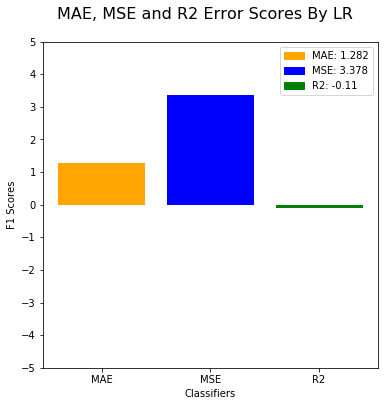

In [18]:
scores = {'scores':[baseline_scores[0], baseline_scores[1], baseline_scores[2]]}

scores_names = ['MAE', 'MSE', 'R2']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
for idx, mthod in zip([i for i in range(1)], scores.keys()):
    ax.bar(scores_names, [round(i,3) for i in scores[mthod]], 
                           align='center', alpha=1.0, color=clr)
    ax.set_yticks([a for a in range(-5,6)])
    legends = []
    for c in range(len(scores_names)):
        legends.append(mpatches.Patch(color=clr[c], label='{}: {}'.format(scores_names[c], 
                                                                          round(scores[mthod][c],3))))
    ax.legend(handles=legends,loc='best')
    ax.set_xlabel('Classifiers')
    ax.set_ylabel('F1 Scores')
# fig.tight_layout()
fig.suptitle('MAE, MSE and R2 Error Scores By LR',
             y=0.96, fontsize=16)
# fig.savefig('error_scores_baseline', dpi=300)